# Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
TARGET = 'Survived'

N_ESTIMATORS = 1000
N_SPLITS = 10
SEED = 2021
EARLY_STOPPING_ROUNDS = 100
VERBOSE = 100

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Load data

In [4]:
train_df = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')
test_df[TARGET] = pd.read_csv("../input/local-tps-apr/pseudo_label.csv")[TARGET]

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Filling missing values

In [5]:
# Age fillna with mean age for each class
all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mean())

# Cabin, fillna with 'X' and take first letter
all_df['Cabin'] = all_df['Cabin'].fillna('X').map(lambda x: x[0].strip())

# Ticket, fillna with 'X', split string and take first split 
all_df['Ticket'] = all_df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

# Fare, fillna with mean value
fare_map = all_df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
all_df['Fare'] = all_df['Fare'].fillna(all_df['Pclass'].map(fare_map['Fare']))
all_df['Fare'] = np.log1p(all_df['Fare'])

# Embarked, fillna with 'X' value
all_df['Embarked'] = all_df['Embarked'].fillna('X')

# Name, take only surnames
all_df['Name'] = all_df['Name'].map(lambda x: x.split(',')[0])

# Encoding

In [6]:
label_cols = ['Name', 'Ticket', 'Sex']
onehot_cols = ['Cabin', 'Embarked']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [7]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()

onehot_encoded_df = pd.get_dummies(all_df[onehot_cols])
label_encoded_df = all_df[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(scaler.fit_transform(all_df[numerical_cols]), columns=numerical_cols)
target_df = all_df[TARGET]

all_df = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df], axis=1)

# LightGBM

In [8]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': N_ESTIMATORS,
    'objective': 'binary',
    'random_state': SEED,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
}

In [9]:
lgb_oof = np.zeros(train_df.shape[0])
lgb_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    pre_model = lgb.LGBMRegressor(**params)
    pre_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE
    )

    params2 = params.copy()
    params2['learning_rate'] = params['learning_rate'] * 0.1
    model = lgb.LGBMRegressor(**params2)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
        init_model=pre_model
    )
    
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = model.feature_name_
    fi_tmp["importance"] = model.feature_importances_
    fi_tmp["fold"] = fold
    fi_tmp["seed"] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    lgb_oof[oof_idx] = model.predict(X_valid)
    lgb_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(lgb_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(lgb_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.406066	valid_1's binary_logloss: 0.510794
[200]	training's binary_logloss: 0.339754	valid_1's binary_logloss: 0.491447
[300]	training's binary_logloss: 0.31865	valid_1's binary_logloss: 0.496066
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.33793	valid_1's binary_logloss: 0.491324
Training until validation scores don't improve for 100 rounds
[300]	training's binary_logloss: 0.334974	valid_1's binary_logloss: 0.491586
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.337838	valid_1's binary_logloss: 0.491328
===== ACCURACY SCORE 0.777767 =====

===== FOLD 1 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.406593	valid_1's binary_logloss: 0.508825
[200]	training's binary_logloss: 0.340467	valid_1's binary_logloss: 0.488658
[300]	training's binary_logloss: 0.31943	valid_1's bina

### Feature importance

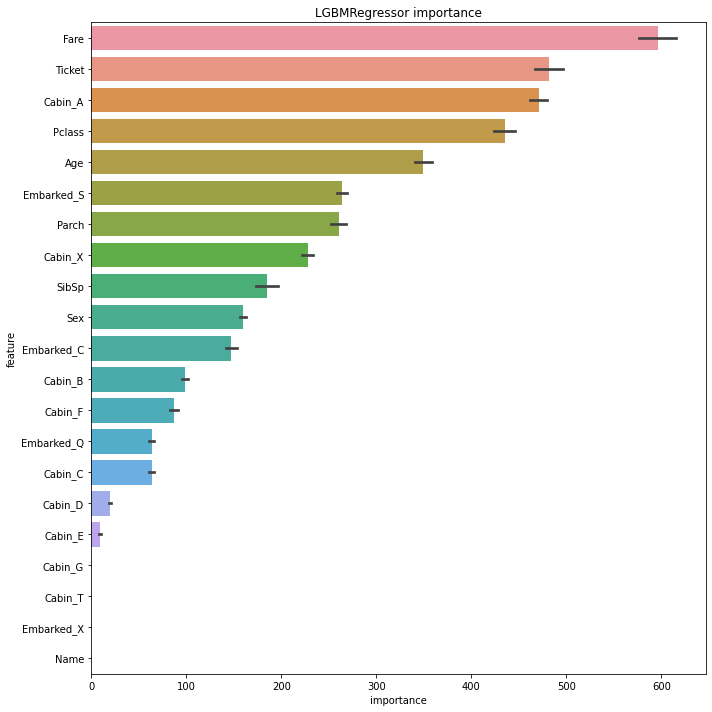

In [10]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("LGBMRegressor"))
plt.tight_layout()

# CatBoost

In [11]:
params = {
    'bootstrap_type': 'Poisson',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': N_ESTIMATORS,
    'max_bin': 280,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}

In [12]:
ctb_oof = np.zeros(train_df.shape[0])
ctb_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    model = ctb.CatBoostClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              use_best_model=True,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS,
              verbose=VERBOSE
              )
    
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = X_test.columns.to_list()
    fi_tmp["importance"] = model.get_feature_importance()
    fi_tmp["fold"] = fold
    fi_tmp["seed"] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    ctb_oof[oof_idx] = model.predict(X_valid)
    ctb_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(ctb_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(ctb_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
0:	learn: 0.6833913	test: 0.6865495	best: 0.6865495 (0)	total: 23.2ms	remaining: 23.2s
100:	learn: 0.3499824	test: 0.4963068	best: 0.4963068 (100)	total: 1.39s	remaining: 12.4s
200:	learn: 0.3147194	test: 0.5005071	best: 0.4952349 (121)	total: 2.69s	remaining: 10.7s
bestTest = 0.4952349318
bestIteration = 121
Shrink model to first 122 iterations.
===== ACCURACY SCORE 0.775094 =====

===== FOLD 1 =====
0:	learn: 0.6834279	test: 0.6864598	best: 0.6864598 (0)	total: 13.9ms	remaining: 13.9s
100:	learn: 0.3505890	test: 0.4918788	best: 0.4918788 (100)	total: 1.31s	remaining: 11.7s
200:	learn: 0.3153961	test: 0.4950116	best: 0.4907642 (130)	total: 2.6s	remaining: 10.3s
bestTest = 0.4907641828
bestIteration = 130
Shrink model to first 131 iterations.
===== ACCURACY SCORE 0.778315 =====

===== FOLD 2 =====
0:	learn: 0.6833830	test: 0.6865852	best: 0.6865852 (0)	total: 14ms	remaining: 14s
100:	learn: 0.3496011	test: 0.5008663	best: 0.5008663 (100)	total: 1.28s	remaining: 11.4s

### Feature importance

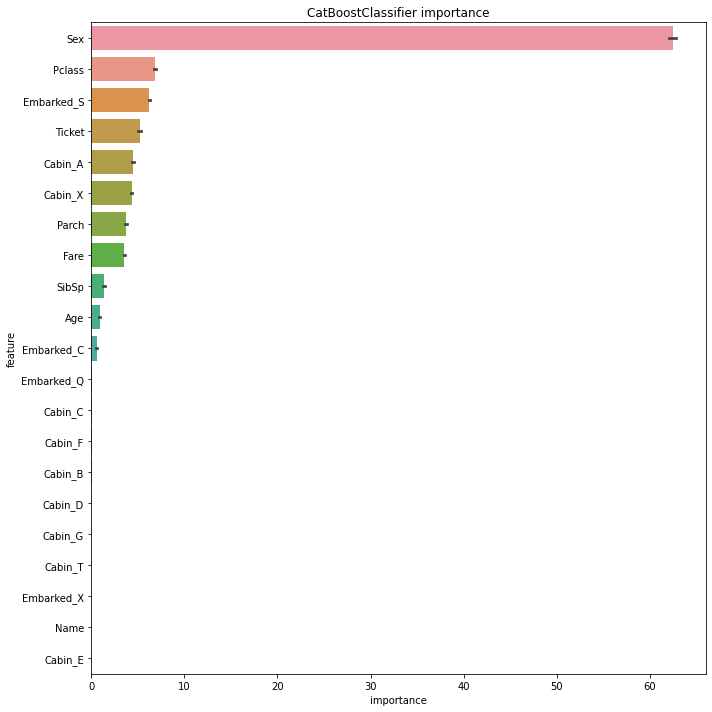

In [13]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("CatBoostClassifier"))
plt.tight_layout()

# DecisionTreeModel

In [14]:
# Tuning the DecisionTreeClassifier by the GridSearchCV
parameters = {
    'max_depth': np.arange(2, 5, dtype=int),
    'min_samples_leaf':  np.arange(2, 5, dtype=int)
}

classifier = DecisionTreeClassifier(random_state=2021)

model = GridSearchCV(
    estimator=classifier,
    param_grid=parameters,
    scoring='accuracy',
    cv=10,
    n_jobs=-1)
model.fit(X_train, y_train)

best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 4, 'min_samples_leaf': 2}


In [15]:
dtm_oof = np.zeros(train_df.shape[0])
dtm_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    model = DecisionTreeClassifier(
        max_depth=best_parameters['max_depth'],
        min_samples_leaf=best_parameters['min_samples_leaf'],
        random_state=SEED
    )
    model.fit(X_train, y_train)
    
    dtm_oof[oof_idx] = model.predict(X_valid)
    dtm_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(dtm_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(dtm_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
===== ACCURACY SCORE 0.769551 =====

===== FOLD 1 =====
===== ACCURACY SCORE 0.773881 =====

===== FOLD 2 =====
===== ACCURACY SCORE 0.769477 =====

===== FOLD 3 =====
===== ACCURACY SCORE 0.770701 =====

===== FOLD 4 =====
===== ACCURACY SCORE 0.762047 =====

===== FOLD 5 =====
===== ACCURACY SCORE 0.772800 =====

===== FOLD 6 =====
===== ACCURACY SCORE 0.773477 =====

===== FOLD 7 =====
===== ACCURACY SCORE 0.770278 =====

===== FOLD 8 =====
===== ACCURACY SCORE 0.776839 =====

===== FOLD 9 =====
===== ACCURACY SCORE 0.779866 =====

===== ACCURACY SCORE 0.771890 =====


### Plot tree

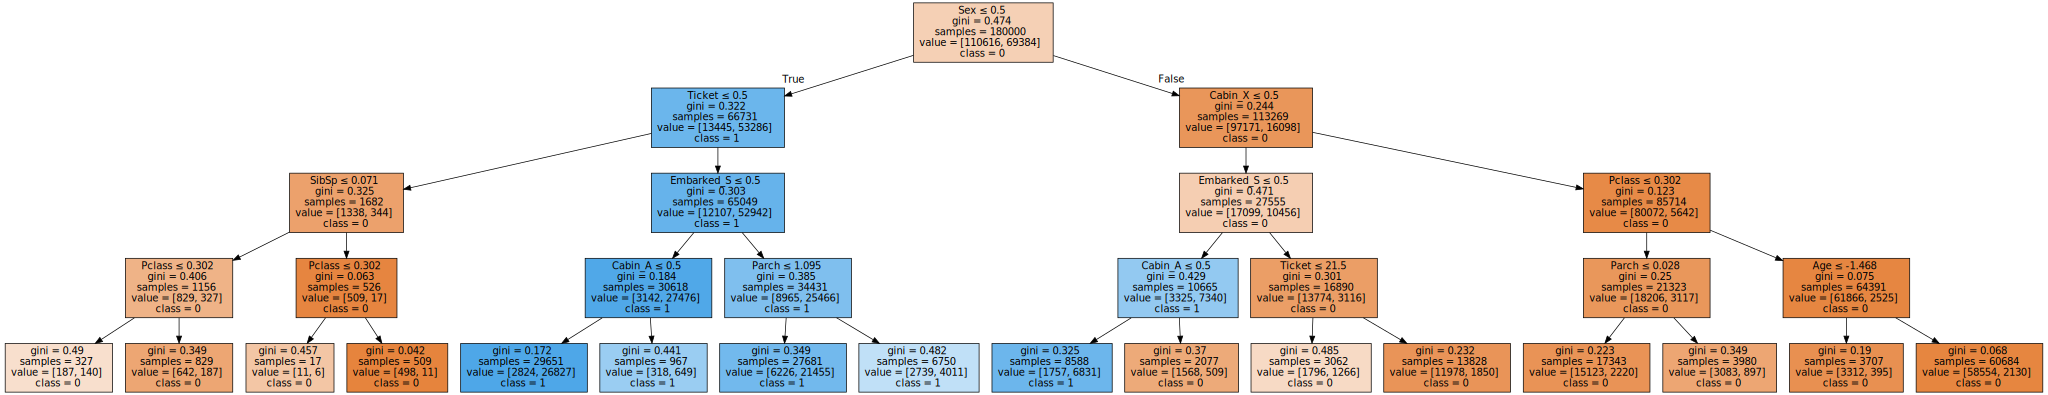

In [16]:
# plot tree
dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    filled=True,
    rounded=False,
    special_characters=True,
    precision=3
)
graph = graphviz.Source(dot_data)
graph 

# Ensemble

In [17]:
submission['submit_lgb'] = np.where(lgb_preds>0.5, 1, 0)
submission['submit_ctb'] = np.where(ctb_preds>0.5, 1, 0)
submission['submit_dtm'] = np.where(dtm_preds>0.5, 1, 0)

In [18]:
submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    63815
3    32606
1     2066
2     1513
dtype: int64

In [19]:
submission[TARGET] = (submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)
submission.drop([col for col in submission.columns if col.startswith('submit_')], axis=1, inplace=True)

# Ensemble/Submission

In [20]:
submission['submit_1'] = submission[TARGET].copy()
submission['submit_2'] = pd.read_csv("../input/local-tps-apr/voting_submission.csv")[TARGET]
submission['submit_3'] = pd.read_csv("../input/local-tps-apr/dae.csv")[TARGET]

In [21]:
submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    65007
3    34037
1      606
2      350
dtype: int64

In [22]:
submission[TARGET] = (submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)

In [23]:
submission[['PassengerId', TARGET]].to_csv("voting_submission.csv", index = False)

<AxesSubplot:>

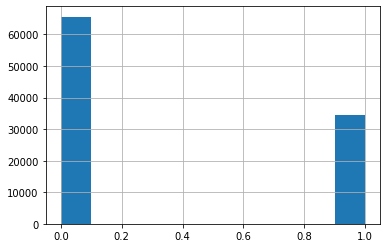

In [24]:
submission[TARGET].hist()